In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import OneBallFreeFallPredictionFromInitialStateWithDiameterDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss as mse_pytorch

import reservoirpy as rpy
from reservoirpy.observables import mse as mse_esn

from itertools import product
from tqdm.notebook import tqdm_notebook

from models import VanilaRNN, GRU, LSTM, ESN, SeqESN, ParallelESN, GroupedESN

rpy.verbosity(0)

0

In [2]:
batch_size = 32

train_data, test_data = OneBallFreeFallPredictionFromInitialStateWithDiameterDataset.train_test_split('../data/raw/single-ball-free-fall-initial-with-diameter', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  1072
train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


In [3]:
for X, y in train_dataloader:
    print(X.shape)
    break

train_data[0][0].shape[1]

torch.Size([32, 1, 2])


2

## Grid-Search of RNN parameters

In [4]:
hidden_dims = [32, 64, 128]
nums_rnns = [1, 2]
dropout_probs = [0, 0.1, 0.15]

In [5]:
results = {'vanila_rnn': []}

In [6]:
for hidden_dim, num_rnns, dropout_prob in product(hidden_dims, nums_rnns, dropout_probs):
    vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=hidden_dim, num_rnns=num_rnns, output_dim=24, dropout_prob=dropout_prob)
    loss = VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=False)
    results['vanila_rnn'].append({
        'hidden_dim': hidden_dim,
        'num_rnns': num_rnns,
        'dropout_prob': dropout_prob,
        'test_loss': loss
    })

VanilaRNN(
  (rnn): RNN(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
)
Epoch 0 complete. Training loss: 3.0598637866787612
Epoch 1 complete. Training loss: 0.502689934335649
Epoch 2 complete. Training loss: 0.3326254489365965
Epoch 3 complete. Training loss: 0.25545575842261314
Epoch 4 complete. Training loss: 0.21351996867451817
Epoch 5 complete. Training loss: 0.18865045835264027
Epoch 6 complete. Training loss: 0.17289571097353473
Epoch 7 complete. Training loss: 0.1623302535736002
Epoch 8 complete. Training loss: 0.1548826929065399
Epoch 9 complete. Training loss: 0.1494007334113121
Epoch 10 complete. Training loss: 0.14521198201691732
Epoch 11 complete. Training loss: 0.14190669578965753
Epoch 12 complete. Training loss: 0.13922504626680166
Epoch 13 complete. Training loss: 0.1369964600307867
Epoch 14 complete. Training loss: 0.13510549068450928
Epoch 15 complete. Training loss: 0.13347191881621256
Epoch 16 complete. Training loss: 0.1320386

/usr/local/anaconda3/envs/capstone/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0 complete. Training loss: 2.3377727810293436
Epoch 1 complete. Training loss: 0.5383982334751636
Epoch 2 complete. Training loss: 0.38526517525315285
Epoch 3 complete. Training loss: 0.3019537115469575
Epoch 4 complete. Training loss: 0.24949968478176743
Epoch 5 complete. Training loss: 0.21513665898237377
Epoch 6 complete. Training loss: 0.19205330236582085
Epoch 7 complete. Training loss: 0.17612758226459846
Epoch 8 complete. Training loss: 0.16479815792990848
Epoch 9 complete. Training loss: 0.15646414569346234
Epoch 10 complete. Training loss: 0.15012152318377048
Epoch 11 complete. Training loss: 0.1451366399996914
Epoch 12 complete. Training loss: 0.14110538712702692
Epoch 13 complete. Training loss: 0.13776567444438115
Epoch 14 complete. Training loss: 0.13494383177021518
Epoch 15 complete. Training loss: 0.13252179062692448
Epoch 16 complete. Training loss: 0.1304168351343833
Epoch 17 complete. Training loss: 0.12856922100763768
Epoch 18 complete. Training loss: 0.1269344

/usr/local/anaconda3/envs/capstone/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0 complete. Training loss: 17.5313728293404
Epoch 1 complete. Training loss: 0.6008105825167149
Epoch 2 complete. Training loss: 0.4554547432344407
Epoch 3 complete. Training loss: 0.3709235799033195
Epoch 4 complete. Training loss: 0.3126154011115432
Epoch 5 complete. Training loss: 0.2696141629712656
Epoch 6 complete. Training loss: 0.2368214586749673
Epoch 7 complete. Training loss: 0.21140926191583276
Epoch 8 complete. Training loss: 0.19158946437528357
Epoch 9 complete. Training loss: 0.176110100466758
Epoch 10 complete. Training loss: 0.16403172787977383
Epoch 11 complete. Training loss: 0.15462190372636542
Epoch 12 complete. Training loss: 0.14729976071976125
Epoch 13 complete. Training loss: 0.1416024639038369
Epoch 14 complete. Training loss: 0.13716294075129554
Epoch 15 complete. Training loss: 0.13369204010814428
Epoch 16 complete. Training loss: 0.13096364866942167
Epoch 17 complete. Training loss: 0.12880286679137498
Epoch 18 complete. Training loss: 0.12707528856117

In [7]:
best_result = min(results['vanila_rnn'], key=lambda x: x['test_loss'])
best_result

{'hidden_dim': 128,
 'num_rnns': 1,
 'dropout_prob': 0,
 'test_loss': tensor(0.0266, grad_fn=<PowBackward0>)}

# Vanila RNN

VanilaRNN(
  (rnn): RNN(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
)
Epoch 0 complete. Training loss: 3.2517784549854696
Epoch 1 complete. Training loss: 0.764773030532524
Epoch 2 complete. Training loss: 0.4868740541860461
Epoch 3 complete. Training loss: 0.3459226439008489
Epoch 4 complete. Training loss: 0.26751498121302575
Epoch 5 complete. Training loss: 0.22167799703311175
Epoch 6 complete. Training loss: 0.19355057238135487
Epoch 7 complete. Training loss: 0.17543062946060672
Epoch 8 complete. Training loss: 0.16320598823949695
Epoch 9 complete. Training loss: 0.15460380376316607
Epoch 10 complete. Training loss: 0.1483177793561481
Epoch 11 complete. Training loss: 0.14356657437747344
Epoch 12 complete. Training loss: 0.13986488670343533
Epoch 13 complete. Training loss: 0.13690098118968308
Epoch 14 complete. Training loss: 0.13446870970074087
Epoch 15 complete. Training loss: 0.1324282243149355
Epoch 16 complete. Training loss: 0.130682

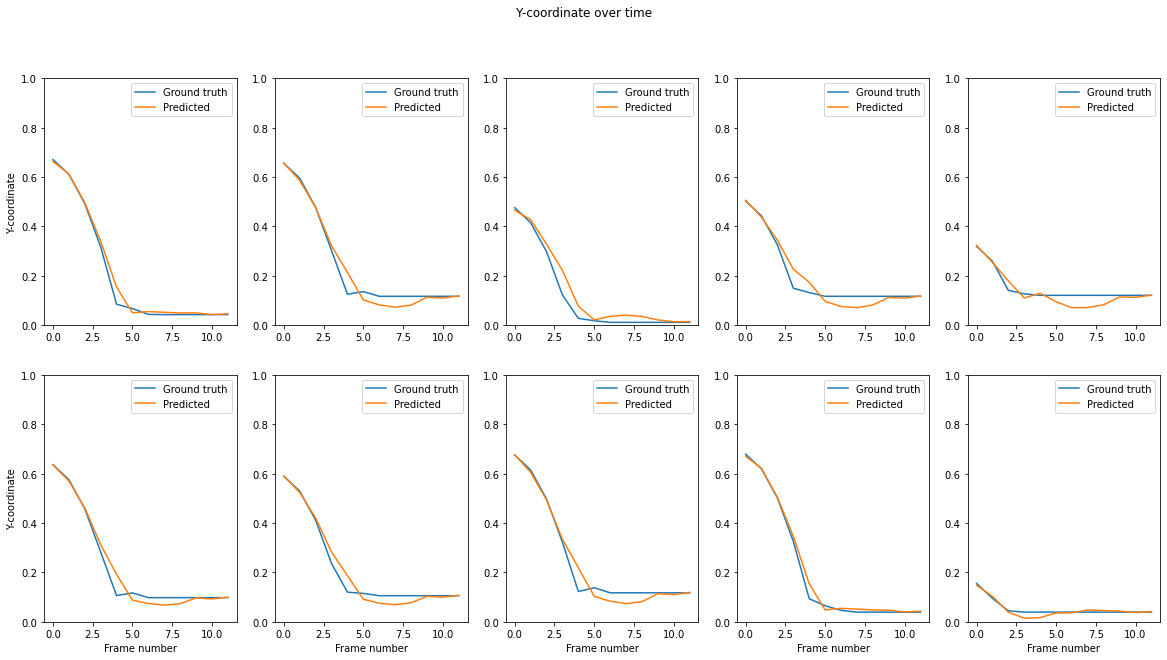

tensor(0.0292, grad_fn=<PowBackward0>)

In [3]:
vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0)
VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## Vanila RNN with ReLU

VanilaRNN(
  (rnn): RNN(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
  (relu): ReLU()
)
Epoch 0 complete. Training loss: 4.183340343646705
Epoch 1 complete. Training loss: 1.9380717249587178
Epoch 2 complete. Training loss: 1.6161135416477919
Epoch 3 complete. Training loss: 1.556170702446252
Epoch 4 complete. Training loss: 1.5208929181098938
Epoch 5 complete. Training loss: 1.5036650854162872
Epoch 6 complete. Training loss: 1.494502766057849
Epoch 7 complete. Training loss: 1.489132972434163
Epoch 8 complete. Training loss: 1.4853791226632893
Epoch 9 complete. Training loss: 1.4821655778214335
Epoch 10 complete. Training loss: 1.4789901999756694
Epoch 11 complete. Training loss: 1.4745816490612924
Epoch 12 complete. Training loss: 1.4673748258501291
Epoch 13 complete. Training loss: 1.4640057440847158
Epoch 14 complete. Training loss: 1.4629955384880304
Epoch 15 complete. Training loss: 1.462304288521409
Training stopped on epoch 15
Calculated

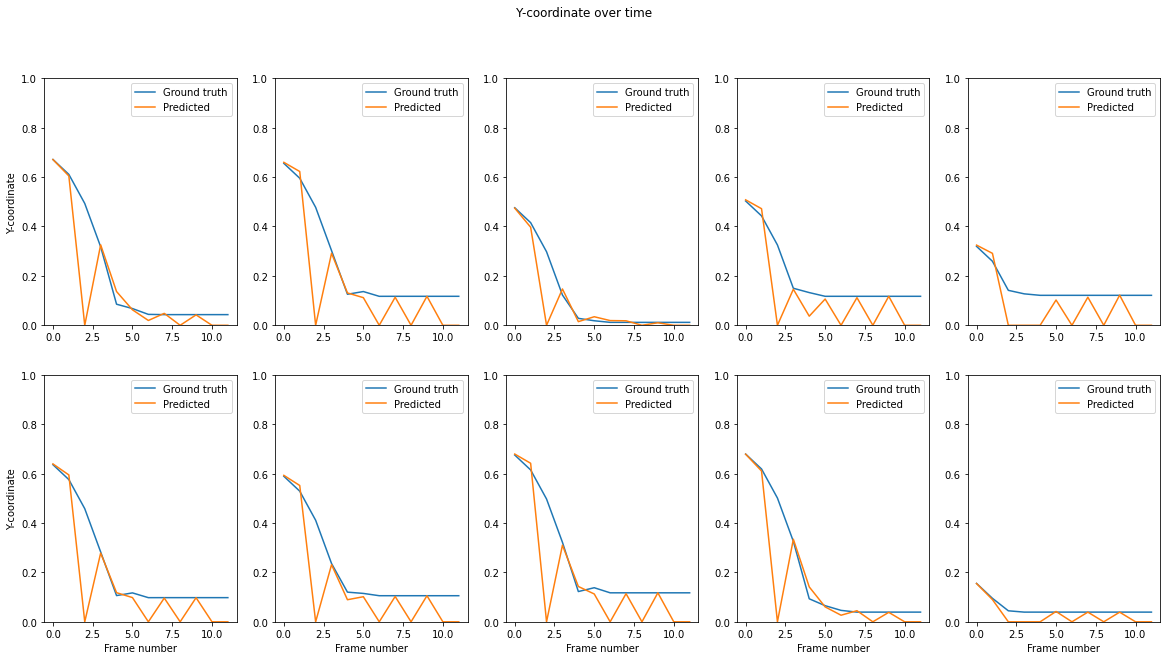

tensor(0.1050, grad_fn=<PowBackward0>)

In [4]:
vanila_rnn_relu = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0, relu=True)
VanilaRNN.calculate_loss(vanila_rnn_relu, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

# GRU

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
)
Epoch 0 complete. Training loss: 2.659383548423648
Epoch 1 complete. Training loss: 1.1037692441605031
Epoch 2 complete. Training loss: 0.8265499430708587
Epoch 3 complete. Training loss: 0.6565990638919175
Epoch 4 complete. Training loss: 0.5379402302205563
Epoch 5 complete. Training loss: 0.4497956382110715
Epoch 6 complete. Training loss: 0.38228082831483334
Epoch 7 complete. Training loss: 0.3297754257218912
Epoch 8 complete. Training loss: 0.2886357579845935
Epoch 9 complete. Training loss: 0.2562801071908325
Epoch 10 complete. Training loss: 0.23077726096380502
Epoch 11 complete. Training loss: 0.2106381757184863
Epoch 12 complete. Training loss: 0.19469767436385155
Epoch 13 complete. Training loss: 0.18203962285770103
Epoch 14 complete. Training loss: 0.17194305470911786
Epoch 15 complete. Training loss: 0.16384224727516994
Epoch 16 complete. Training loss: 0.1572951676207594

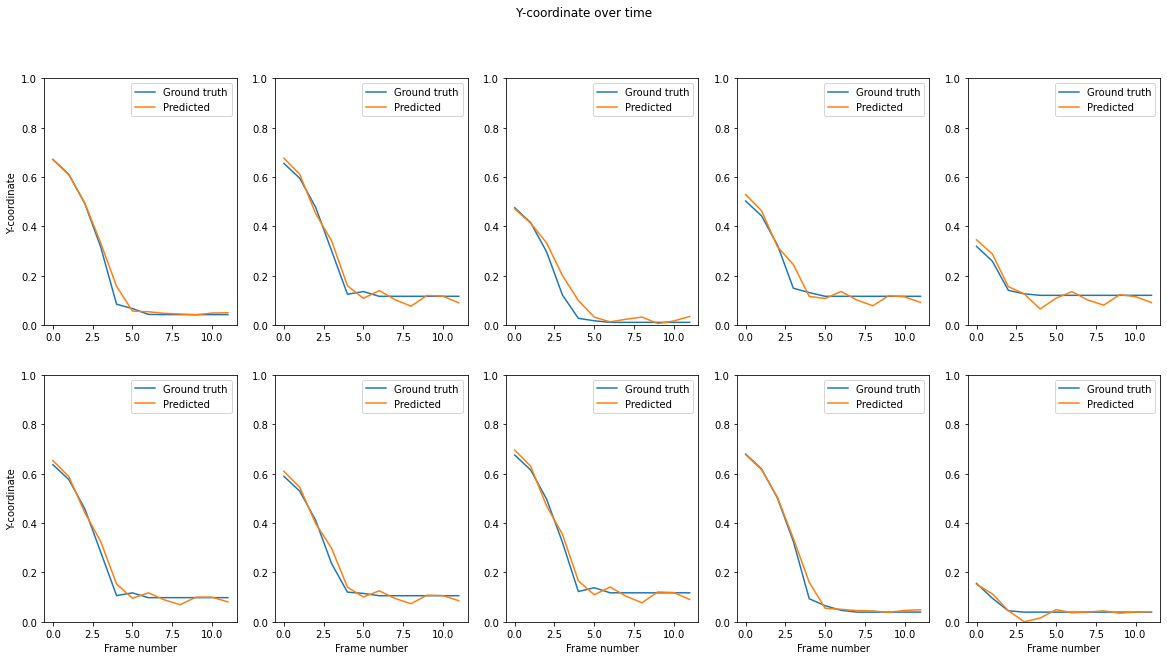

tensor(0.0284, grad_fn=<PowBackward0>)

In [5]:
gru = GRU.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0)
GRU.calculate_loss(gru, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
  (relu): ReLU()
)
Epoch 0 complete. Training loss: 3.276543007232249
Epoch 1 complete. Training loss: 1.9285888243466616
Epoch 2 complete. Training loss: 1.6092078434303403
Epoch 3 complete. Training loss: 1.4693421912379563
Epoch 4 complete. Training loss: 1.3932014969177544
Epoch 5 complete. Training loss: 1.3471212135627866
Epoch 6 complete. Training loss: 1.31610875017941
Epoch 7 complete. Training loss: 1.3018187186680734
Epoch 8 complete. Training loss: 1.294898247346282
Epoch 9 complete. Training loss: 1.2908136234618723
Epoch 10 complete. Training loss: 1.2877827784977853
Epoch 11 complete. Training loss: 1.2852452625520527
Epoch 12 complete. Training loss: 1.2829219046980143
Epoch 13 complete. Training loss: 1.2806659089401364
Epoch 14 complete. Training loss: 1.2783768684603274
Epoch 15 complete. Training loss: 1.2759470590390265
Epoch 16 complete. Training loss: 1.27341489

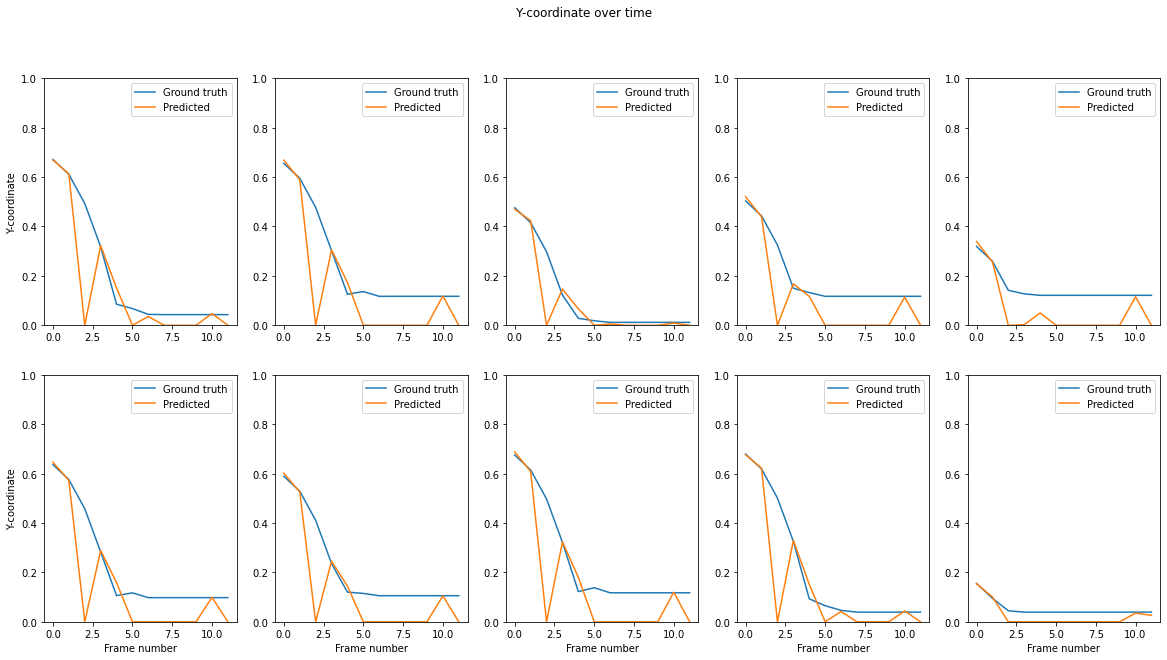

tensor(0.0961, grad_fn=<PowBackward0>)

In [6]:
gru_relu = GRU.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0, relu=True)
GRU.calculate_loss(gru_relu, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

# LSTM

LSTM(
  (lstm): LSTM(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
)
Epoch 0 complete. Training loss: 4.485552130267024
Epoch 1 complete. Training loss: 2.026637449860573
Epoch 2 complete. Training loss: 1.6969248997047544
Epoch 3 complete. Training loss: 1.487116739153862
Epoch 4 complete. Training loss: 1.3280455977655947
Epoch 5 complete. Training loss: 1.2009057593531907
Epoch 6 complete. Training loss: 1.0959452870301902
Epoch 7 complete. Training loss: 1.0072543853893876
Epoch 8 complete. Training loss: 0.9309968850575387
Epoch 9 complete. Training loss: 0.864550621714443
Epoch 10 complete. Training loss: 0.8060415587387979
Epoch 11 complete. Training loss: 0.7540798070840538
Epoch 12 complete. Training loss: 0.7076022278051823
Epoch 13 complete. Training loss: 0.6657740236259997
Epoch 14 complete. Training loss: 0.6279268809594214
Epoch 15 complete. Training loss: 0.5935165002010763
Epoch 16 complete. Training loss: 0.5620945238042623
Epoch

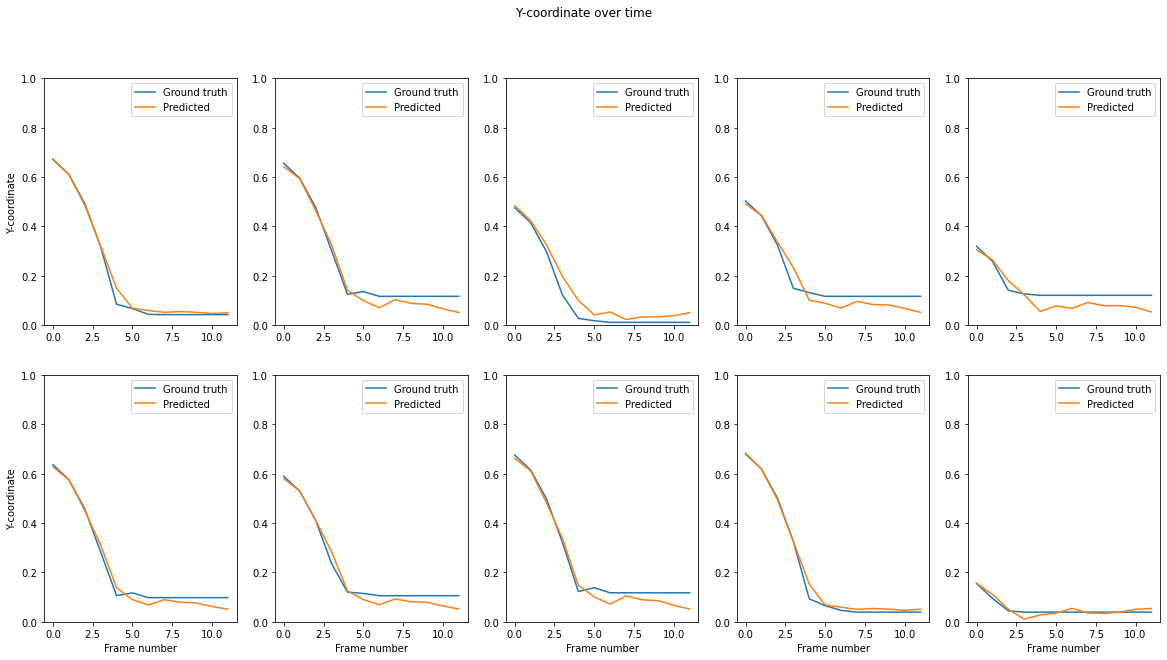

tensor(0.0295, grad_fn=<PowBackward0>)

In [7]:
lstm = LSTM.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0)
LSTM.calculate_loss(lstm, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

LSTM(
  (lstm): LSTM(2, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=24, bias=True)
  (relu): ReLU()
)
Epoch 0 complete. Training loss: 4.55891137290746
Epoch 1 complete. Training loss: 3.454777805134654
Epoch 2 complete. Training loss: 3.2672377601265907
Epoch 3 complete. Training loss: 3.1356362299993634
Epoch 4 complete. Training loss: 3.0381770310923457
Epoch 5 complete. Training loss: 2.9634326063096523
Epoch 6 complete. Training loss: 2.9037795774638653
Epoch 7 complete. Training loss: 2.8543285597115755
Epoch 8 complete. Training loss: 2.7797208623960614
Epoch 9 complete. Training loss: 2.4555443301796913
Epoch 10 complete. Training loss: 1.9183472855947912
Epoch 11 complete. Training loss: 0.9193127639591694
Epoch 12 complete. Training loss: 0.7762305503711104
Epoch 13 complete. Training loss: 0.6787212567869574
Epoch 14 complete. Training loss: 0.6015924371313304
Epoch 15 complete. Training loss: 0.5399469041731209
Epoch 16 complete. Training loss: 0.4903

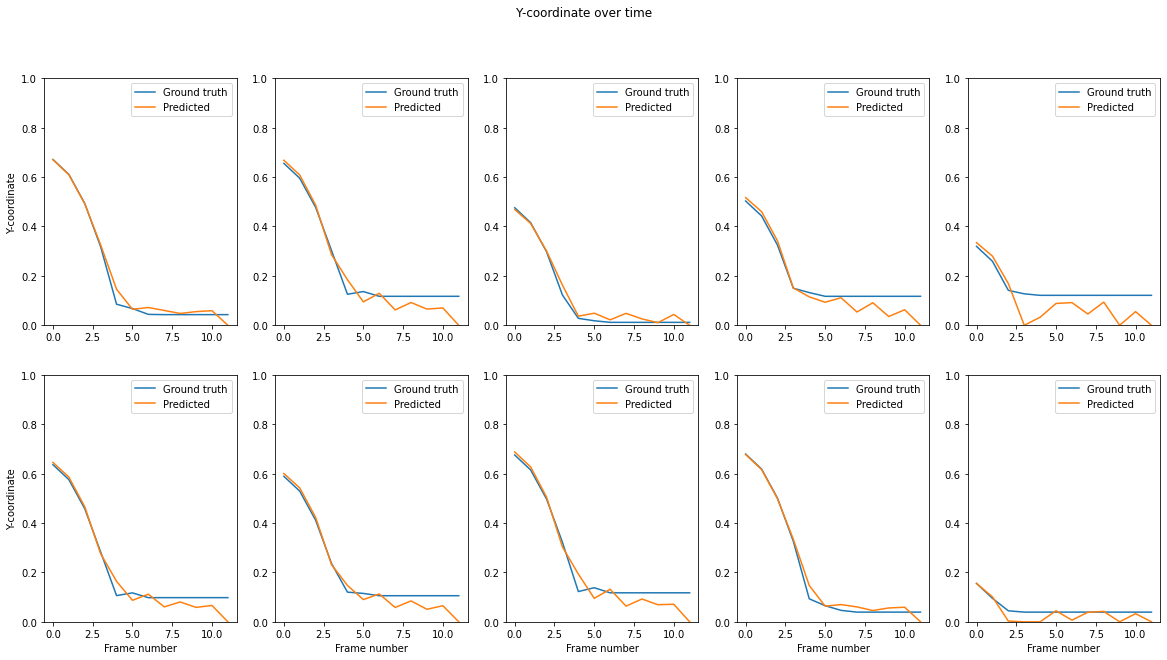

tensor(0.0382, grad_fn=<PowBackward0>)

In [8]:
lstm_relu = LSTM.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=2, hidden_dim=32, num_rnns=1, output_dim=24, dropout_prob=0, relu=True)
LSTM.calculate_loss(lstm_relu, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## ESN

'Model-0': Model('Reservoir-0', 'Ridge-0')
Test loss:  0.04788242759348829


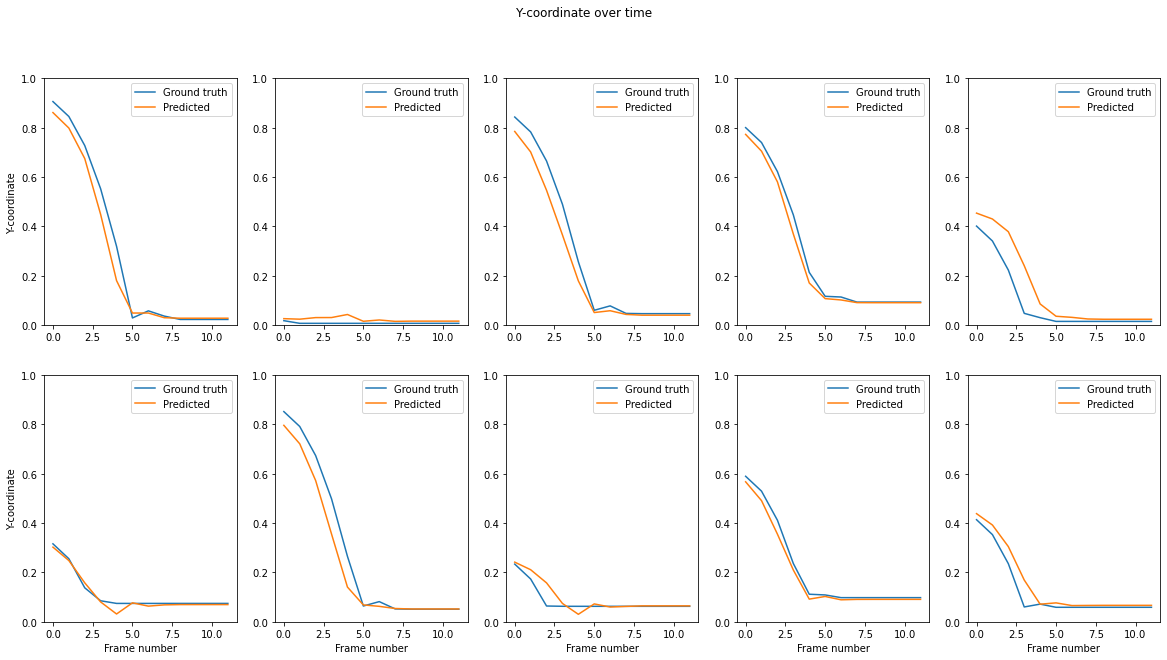

In [3]:
rpy.set_seed(42)

esn = ESN.train_model(train_dataloader=train_dataloader, input_dim=2, reservoir_size=70, output_dim=24, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01)
esn_loss = ESN.calculate_loss(esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## SeqESN

'Model-91': Model('Input-8', 'Reservoir-90', 'Ridge-42', 'Reservoir-91', 'Ridge-43')
Test loss:  0.036096785873450554


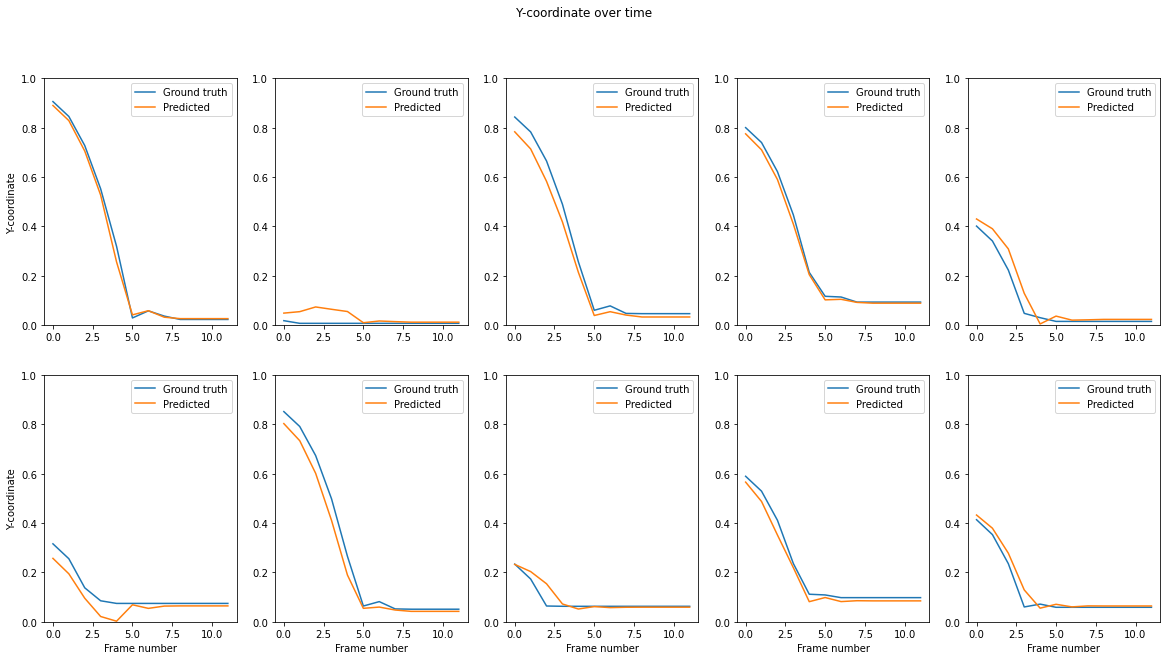

'Model-97': Model('Input-9', 'Reservoir-92', 'Ridge-44', 'Reservoir-93', 'Ridge-45', 'Reservoir-94', 'Ridge-46')
Test loss:  0.042502258706567084
'Model-105': Model('Input-10', 'Reservoir-95', 'Ridge-47', 'Reservoir-96', 'Ridge-48', 'Reservoir-97', 'Ridge-49', 'Reservoir-98', 'Ridge-50')
Test loss:  0.05204540391409866
'Model-115': Model('Input-11', 'Reservoir-99', 'Ridge-51', 'Reservoir-100', 'Ridge-52', 'Reservoir-101', 'Ridge-53', 'Reservoir-102', 'Ridge-54', 'Reservoir-103', 'Ridge-55')
Test loss:  0.04225073251399832
'Model-127': Model('Input-12', 'Reservoir-104', 'Ridge-56', 'Reservoir-105', 'Ridge-57', 'Reservoir-106', 'Ridge-58', 'Reservoir-107', 'Ridge-59', 'Reservoir-108', 'Ridge-60', 'Reservoir-109', 'Ridge-61')
Test loss:  0.04487337463921196
'Model-141': Model('Input-13', 'Reservoir-110', 'Ridge-62', 'Reservoir-111', 'Ridge-63', 'Reservoir-112', 'Ridge-64', 'Reservoir-113', 'Ridge-65', 'Reservoir-114', 'Ridge-66', 'Reservoir-115', 'Ridge-67', 'Reservoir-116', 'Ridge-68')
T

In [27]:
rpy.set_seed(42)

seq_loss = [esn_loss]

for i in range(2, 11):
    seq_esn = SeqESN.train_model(train_dataloader=train_dataloader, input_dim=2, reservoir_size=70, output_dim=24, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=i)
    seq_loss.append(SeqESN.calculate_loss(seq_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=(i==2)))

## Parallel ESN

'Model-197': Model('Reservoir-145', 'Reservoir-144', 'Concat-23', 'Ridge-96')
Test loss:  0.039090884268313336


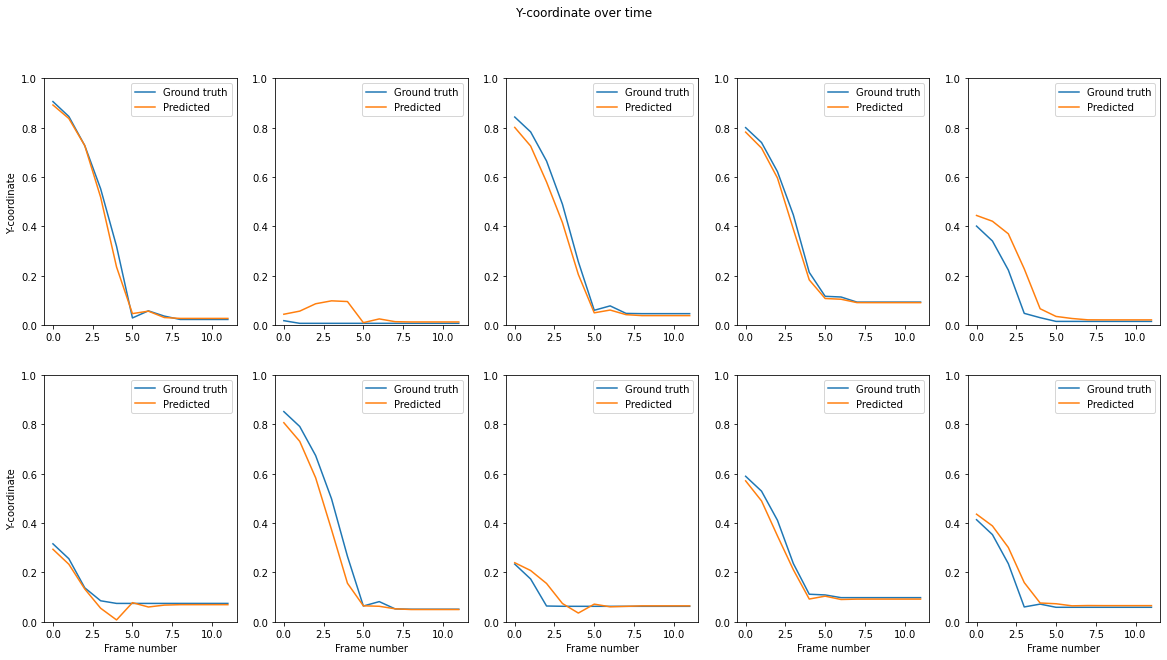

'Model-200': Model('Reservoir-148', 'Reservoir-146', 'Reservoir-147', 'Concat-24', 'Ridge-97')
Test loss:  0.03241007022510251
'Model-204': Model('Reservoir-151', 'Reservoir-150', 'Reservoir-152', 'Reservoir-149', 'Concat-25', 'Ridge-98')
Test loss:  0.050494129017201336
'Model-209': Model('Reservoir-157', 'Reservoir-153', 'Reservoir-154', 'Reservoir-155', 'Reservoir-156', 'Concat-26', 'Ridge-99')
Test loss:  0.03743806086915251
'Model-215': Model('Reservoir-161', 'Reservoir-159', 'Reservoir-158', 'Reservoir-163', 'Reservoir-162', 'Reservoir-160', 'Concat-27', 'Ridge-100')
Test loss:  0.04347274460783912
'Model-222': Model('Reservoir-165', 'Reservoir-166', 'Reservoir-167', 'Reservoir-164', 'Reservoir-168', 'Reservoir-169', 'Reservoir-170', 'Concat-28', 'Ridge-101')
Test loss:  0.03859897630794669
'Model-230': Model('Reservoir-177', 'Reservoir-174', 'Reservoir-172', 'Reservoir-175', 'Reservoir-173', 'Reservoir-171', 'Reservoir-176', 'Reservoir-178', 'Concat-29', 'Ridge-102')
Test loss: 

In [28]:
rpy.set_seed(42)

parallel_loss = [esn_loss]

for i in range(2, 11):
    parallel_esn = ParallelESN.train_model(train_dataloader=train_dataloader, input_dim=2, reservoir_size=70, output_dim=24, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=i)
    parallel_loss.append(ParallelESN.calculate_loss(parallel_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=(i==2)))

## Grouped ESN

'Model-250': Model('Reservoir-198', 'Reservoir-199', 'Concat-32', 'Ridge-105')
Test loss:  0.04946843779936595


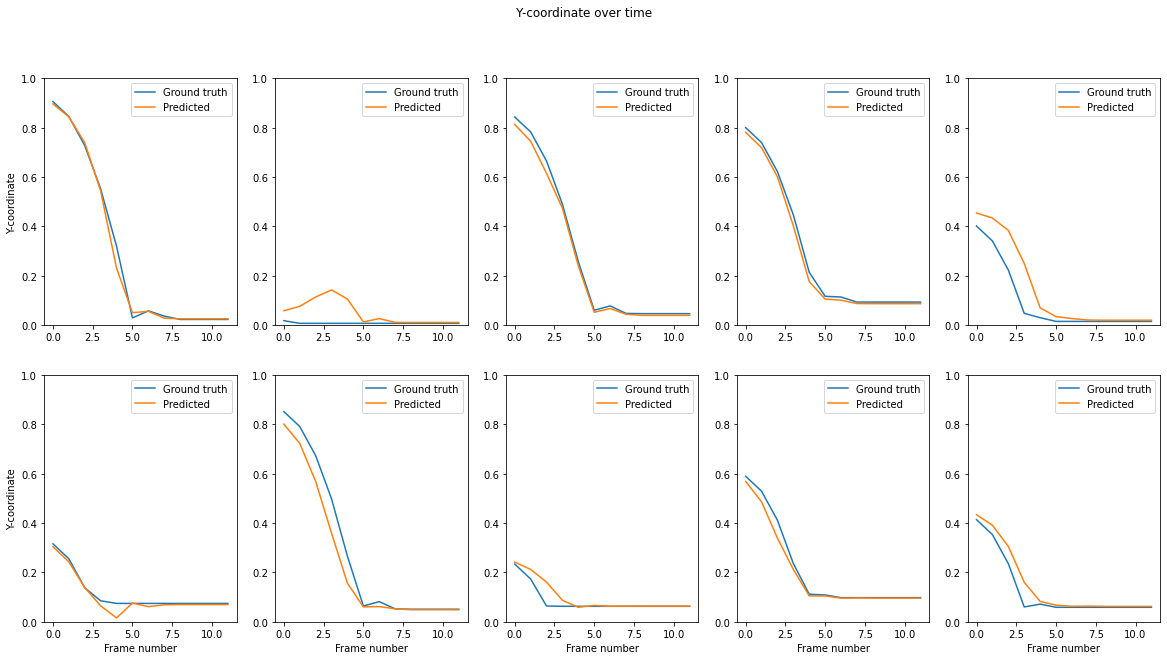

'Model-251': Model('Reservoir-201', 'Reservoir-200', 'Reservoir-202', 'Concat-33', 'Ridge-106')
Test loss:  0.04065584961857455
'Model-252': Model('Reservoir-205', 'Reservoir-206', 'Reservoir-203', 'Reservoir-204', 'Concat-34', 'Ridge-107')
Test loss:  0.04645669236445726
'Model-253': Model('Reservoir-209', 'Reservoir-207', 'Reservoir-211', 'Reservoir-208', 'Reservoir-210', 'Concat-35', 'Ridge-108')
Test loss:  0.04354087124981175
'Model-254': Model('Reservoir-215', 'Reservoir-213', 'Reservoir-214', 'Reservoir-217', 'Reservoir-216', 'Reservoir-212', 'Concat-36', 'Ridge-109')
Test loss:  0.03937278038293475
'Model-255': Model('Reservoir-224', 'Reservoir-220', 'Reservoir-222', 'Reservoir-219', 'Reservoir-218', 'Reservoir-221', 'Reservoir-223', 'Concat-37', 'Ridge-110')
Test loss:  0.04022684170375436
'Model-256': Model('Reservoir-226', 'Reservoir-228', 'Reservoir-231', 'Reservoir-232', 'Reservoir-229', 'Reservoir-225', 'Reservoir-227', 'Reservoir-230', 'Concat-38', 'Ridge-111')
Test loss

In [29]:
grouped_loss = [esn_loss]

for i in range(2, 11):
    grouped_esn = GroupedESN.train_model(train_dataloader=train_dataloader, input_dim=2, reservoir_size=70, output_dim=24, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=i)
    grouped_loss.append(GroupedESN.calculate_loss(grouped_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=(i==2)))

## ESN Plots

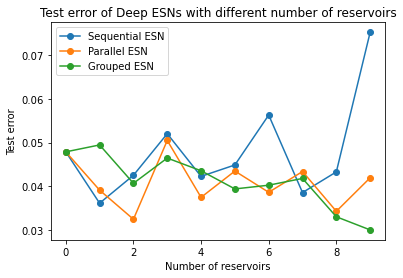

In [30]:
plt.plot(seq_loss, marker='o', label='Sequential ESN')
plt.plot(parallel_loss, marker='o', label='Parallel ESN')
plt.plot(grouped_loss, marker='o', label='Grouped ESN')
plt.legend()
plt.xlabel('Number of reservoirs')
plt.ylabel('Test error')
plt.title('Test error of Deep ESNs with different number of reservoirs')
plt.show()